In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Leads.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


# EDA and Data imputation.
- Both these will go hand in hand as there are too many variables and we will have to keep reading the data to - 
    1. Drop columns 
    2. Delete records
    3. Impute data

## Broad Data understanding - Initial reads 
1. 9240 records and 37 columns. Too many columns to handle, so first task will be to identify columns that can be dropped. 
2. Most of the columns have categorical data / Object information in it. Hence EDA will is likely to be more detailed to undertstand patterns. 
3. Considerable data missing in some columns

In [5]:
df.shape

(9240, 37)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

### Only few columns with numerical data. 
1. There could be outliers in Total Visits, Total time spent on website, page views per visit
2. Converted is the main target variable. Data looks fine in that. 

In [7]:
df.describe().round(2)

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.00,9240.00,9103.00,9240.00,9103.00,5022.00,5022.00
mean,617188.44,0.39,3.45,487.70,2.36,14.31,16.34
std,23406.00,0.49,4.85,548.02,2.16,1.39,1.81
min,579533.00,0.00,0.00,0.00,0.00,7.00,11.00
25%,596484.50,0.00,1.00,12.00,1.00,14.00,15.00
50%,615479.00,0.00,3.00,248.00,2.00,14.00,16.00
75%,637387.25,1.00,5.00,936.00,3.00,15.00,18.00
max,660737.00,1.00,251.00,2272.00,55.00,18.00,20.00


### There are no duplicates in this data. 

In [8]:
(~df.duplicated()).sum()

9240

### There are quite a few columns with missing data.
1. Let's look at anything above 30% missing data to identify columns that can be dropped. 
2. We just need to get a sense of what these columns are, especially the ones between the 30%-40% missing data.
3. We can drop the following - Lead Quality, Asymmetrique Activity Index, Asymmetrique Profile Score, Asymmetrique Activity Score, Asymmetrique Profile Index as there is considerable data missing. Also these are all some derived variables based on activity and profile (as given in the data dictionary). We don't know if this also has judgement of people handling this data. So the logic is not clear for assigning column contents. 
4. We will also consider the 'Select' response and convert it to Nan. 

In [9]:
df = df.replace('Select', np.nan)

In [10]:
round(((df.isnull().sum().sort_values(ascending=False))/len(df))*100)

How did you hear about X Education               78.0
Lead Profile                                     74.0
Lead Quality                                     52.0
Asymmetrique Profile Score                       46.0
Asymmetrique Activity Score                      46.0
Asymmetrique Activity Index                      46.0
Asymmetrique Profile Index                       46.0
City                                             40.0
Specialization                                   37.0
Tags                                             36.0
What matters most to you in choosing a course    29.0
What is your current occupation                  29.0
Country                                          27.0
Page Views Per Visit                              1.0
TotalVisits                                       1.0
Last Activity                                     1.0
Lead Source                                       0.0
Receive More Updates About Our Courses            0.0
I agree to pay the amount th

In [11]:
df['Asymmetrique Activity Index'].value_counts()

02.Medium    3839
01.High       821
03.Low        362
Name: Asymmetrique Activity Index, dtype: int64

In [12]:
df['Asymmetrique Activity Score'].value_counts()

14.0    1771
15.0    1293
13.0     775
16.0     467
17.0     349
12.0     196
11.0      95
10.0      57
9.0        9
18.0       5
8.0        4
7.0        1
Name: Asymmetrique Activity Score, dtype: int64

In [13]:
df['Asymmetrique Profile Index'].value_counts()

02.Medium    2788
01.High      2203
03.Low         31
Name: Asymmetrique Profile Index, dtype: int64

In [16]:
df['Lead Profile'].value_counts()

Potential Lead                 1613
Other Leads                     487
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64

In [17]:
(df['City'].value_counts(normalize=True)*100).round(2)

Mumbai                         57.84
Thane & Outskirts              13.50
Other Cities                   12.31
Other Cities of Maharashtra     8.20
Other Metro Cities              6.82
Tier II Cities                  1.33
Name: City, dtype: float64

In [18]:
(df['Specialization'].value_counts(normalize=True)*100).round(2)

Finance Management                   16.66
Human Resource Management            14.47
Marketing Management                 14.30
Operations Management                 8.58
Business Administration               6.88
IT Projects Management                6.25
Supply Chain Management               5.96
Banking, Investment And Insurance     5.77
Travel and Tourism                    3.46
Media and Advertising                 3.46
International Business                3.04
Healthcare Management                 2.71
Hospitality Management                1.95
E-COMMERCE                            1.91
Retail Management                     1.71
Rural and Agribusiness                1.25
E-Business                            0.97
Services Excellence                   0.68
Name: Specialization, dtype: float64

### It makes sense to drop columns as these have very high >40% missing data. 
- Any imputation will make the output unstable in this case. 
- Also, most of these columns are derived metrices, for which we really do not have clear reasoning or logic provided. 

In [19]:
df=df.drop(columns=['How did you hear about X Education','Lead Quality','Lead Profile',
                                  'Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score',
                                 'Asymmetrique Profile Score'])

In [277]:
df.shape

## We have dropped 7 columns and it can be seen in the shape that we have 30 columns now

(9093, 10)

In [21]:
round(((df.isnull().sum().sort_values(ascending=False))/len(df))*100)

City                                             40.0
Specialization                                   37.0
Tags                                             36.0
What matters most to you in choosing a course    29.0
What is your current occupation                  29.0
Country                                          27.0
Page Views Per Visit                              1.0
TotalVisits                                       1.0
Last Activity                                     1.0
Lead Source                                       0.0
Through Recommendations                           0.0
Receive More Updates About Our Courses            0.0
Prospect ID                                       0.0
Newspaper                                         0.0
Update me on Supply Chain Content                 0.0
Get updates on DM Content                         0.0
I agree to pay the amount through cheque          0.0
A free copy of Mastering The Interview            0.0
Digital Advertisement       

## Handling missing data in selected columns 
1. City - DROP COLUMN - This is because, in the records where we have data, it is primarily Mumbai, followed by Thane / Tier 1-2 cities. Actually if we even replace NaN with any of these, it would mean changing the data considerably without even knowing if people really belong to these cities. Secondly, if impute the missing data as only 'Others' that will also skew the output, as it is a considerable 30%+ records.

2. Specialization - DROP COLUMN- Again, we do not have any clarity on how to impute and the missing data proportion is very high. There are 3-4 specializations which are at par. 

3. Tags DROP COLUMN - Fragmented response and hence difficult to impute
5. What is your current occupation - DROP COLUMN- Mostly unemployed. Again for the reasons are similar to previous ones for dropping this column too. 

4. What matters most to you in choosing a course - DROP COLUMN - Only one response for most respondents ' Better career opportunities'. Hence makes sense to drop. 

6. Country - DROP COLUMN- Everything is India. It will not have any bearing on the overall output. 


7. Page Views Per Visit - Check Imputation/deletion of records later,  as onlt 1% records missing
8. TotalVisits - Check Imputation/deletion of records later,  as onlt 1% records missing
9. Last Activity  - Check Imputation/deletion of records later,  as onlt 1% records missing

In [22]:
(df['Converted'].value_counts(normalize=True)*100).round(2)

0    61.46
1    38.54
Name: Converted, dtype: float64

In [23]:
df.Converted= df.Converted.replace(0, 'Undecided')
df.Converted= df.Converted.replace(1, 'Converted')

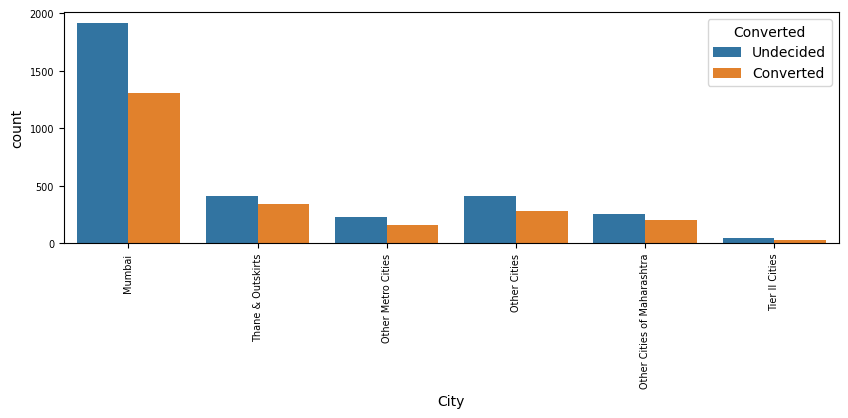

In [24]:
plt.figure(figsize=(10,3))
sns.countplot(df['City'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.show()

#### This is very fragmented. Hence imputation cannot be done. 

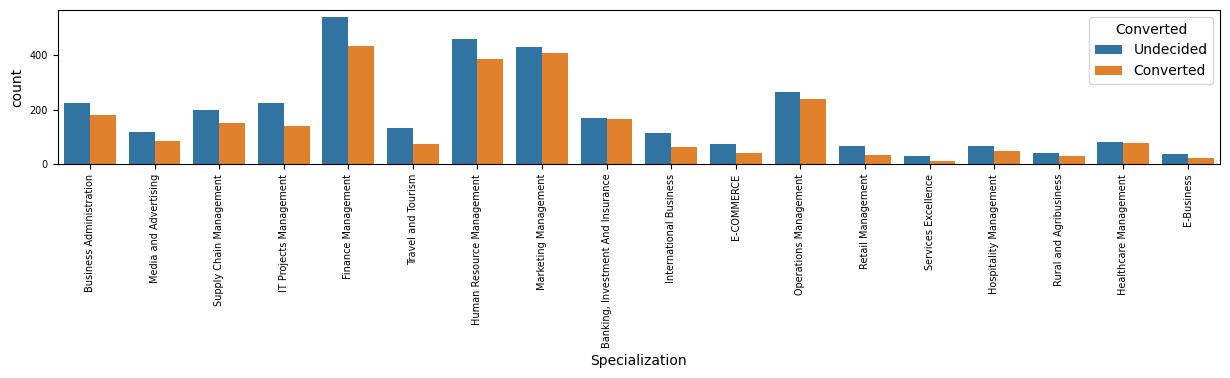

In [25]:
plt.figure(figsize=(15,2))
sns.countplot(df.Specialization, hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.show()

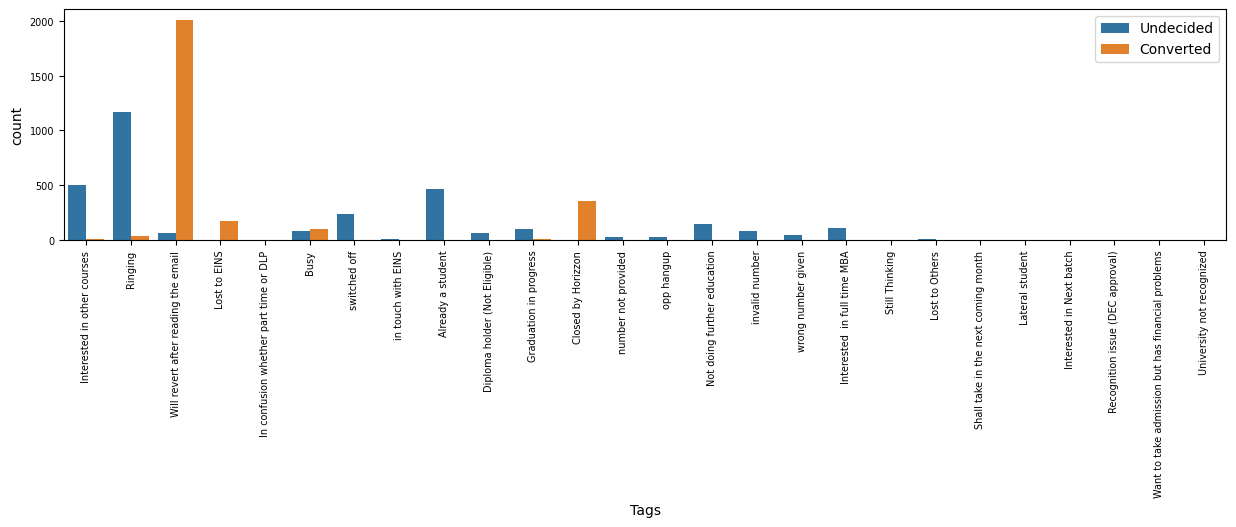

In [26]:
plt.figure(figsize=(15,3))
sns.countplot(df.Tags, hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(loc=1)
plt.show()

#### We can drop this column as there is only one response

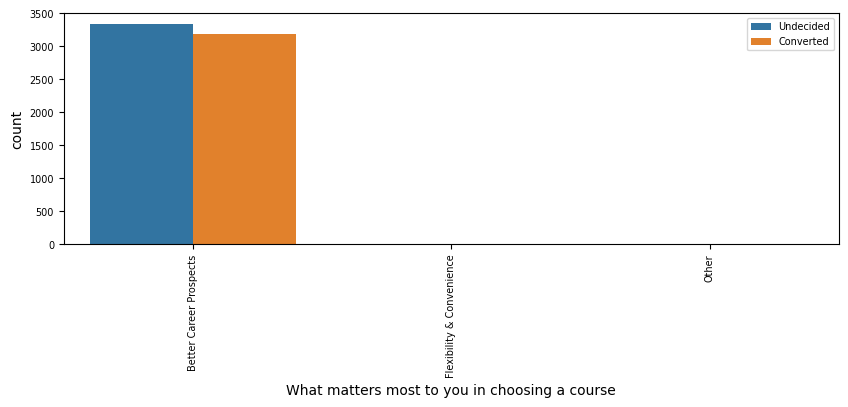

In [27]:
plt.figure(figsize=(10,3))
sns.countplot(df['What matters most to you in choosing a course'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(loc=1, fontsize =7)
plt.show()

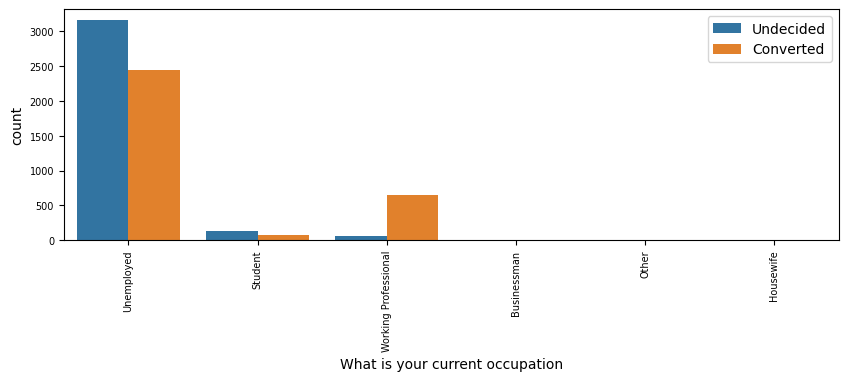

In [28]:
plt.figure(figsize=(10,3))
sns.countplot(df['What is your current occupation'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(loc=1)
plt.show()

## Second list of dropping columns based on aforementioned analysis.

In [29]:
df=df.drop(columns=['Tags','City', 'Country', 'Specialization', 
                    'What matters most to you in choosing a course', 'What is your current occupation'])

In [30]:
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,Undecided,0.0,0,0.0,Page Visited on Website,No,No,No,No,No,No,No,No,No,No,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,Undecided,5.0,674,2.5,Email Opened,No,No,No,No,No,No,No,No,No,No,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,Converted,2.0,1532,2.0,Email Opened,No,No,No,No,No,No,No,No,No,No,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,Undecided,1.0,305,1.0,Unreachable,No,No,No,No,No,No,No,No,No,No,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,Converted,2.0,1428,1.0,Converted to Lead,No,No,No,No,No,No,No,No,No,No,No,No,Modified


In [31]:
df.shape

(9240, 24)

In [32]:
(df['Newspaper Article'].value_counts(normalize=True)*100).round(2)

No     99.98
Yes     0.02
Name: Newspaper Article, dtype: float64

In [33]:
(df['Magazine'].value_counts(normalize=True)*100).round(2)

No    100.0
Name: Magazine, dtype: float64

In [34]:
(df['Search'].value_counts(normalize=True)*100).round(2)

No     99.85
Yes     0.15
Name: Search, dtype: float64

In [35]:
(df['Digital Advertisement'].value_counts(normalize=True)*100).round(2)

No     99.96
Yes     0.04
Name: Digital Advertisement, dtype: float64

In [36]:
(df['X Education Forums'].value_counts(normalize=True)*100).round(2)

No     99.99
Yes     0.01
Name: X Education Forums, dtype: float64

In [37]:
(df['Newspaper'].value_counts(normalize=True)*100).round(2)

No     99.99
Yes     0.01
Name: Newspaper, dtype: float64

### Source of awareness is all with only one response ,ie, 'No', hence makes sense to drop these columns as well
- We will also drop Lead Number and Prospect ID

In [38]:
df=df.drop(columns=['Newspaper', 'X Education Forums','Digital Advertisement', 'Magazine', 'Search','Newspaper Article'])

In [39]:
df.shape

(9240, 18)

In [40]:
df=df.drop(columns=['Prospect ID','Lead Number'])

In [41]:
df.shape

(9240, 16)

In [42]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,Undecided,0.0,0,0.0,Page Visited on Website,No,No,No,No,No,No,Modified
1,API,Organic Search,No,No,Undecided,5.0,674,2.5,Email Opened,No,No,No,No,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,Converted,2.0,1532,2.0,Email Opened,No,No,No,No,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,Undecided,1.0,305,1.0,Unreachable,No,No,No,No,No,No,Modified
4,Landing Page Submission,Google,No,No,Converted,2.0,1428,1.0,Converted to Lead,No,No,No,No,No,No,Modified


## Outliers and Data Imputation.
- Outliers removed in TotalVisits and Page Views per Visit. 
- Also NaN records deleted
- This is being for only three numerical variables that we had listed earlier

- Our approach - 
    1. Plotting the boxplot. Where we see that outliers can be seen in TotalVisits and Page views per visit. 
    2. We drop records which break away from the continuous outliers. The continuous outliers are retained. 
    3. The records with NaN are dropped from the dataframe. 
    4. From 9240 records, we are now left with 9093 records. This translates to 1.5% records being dropped, which is a very 
       low number

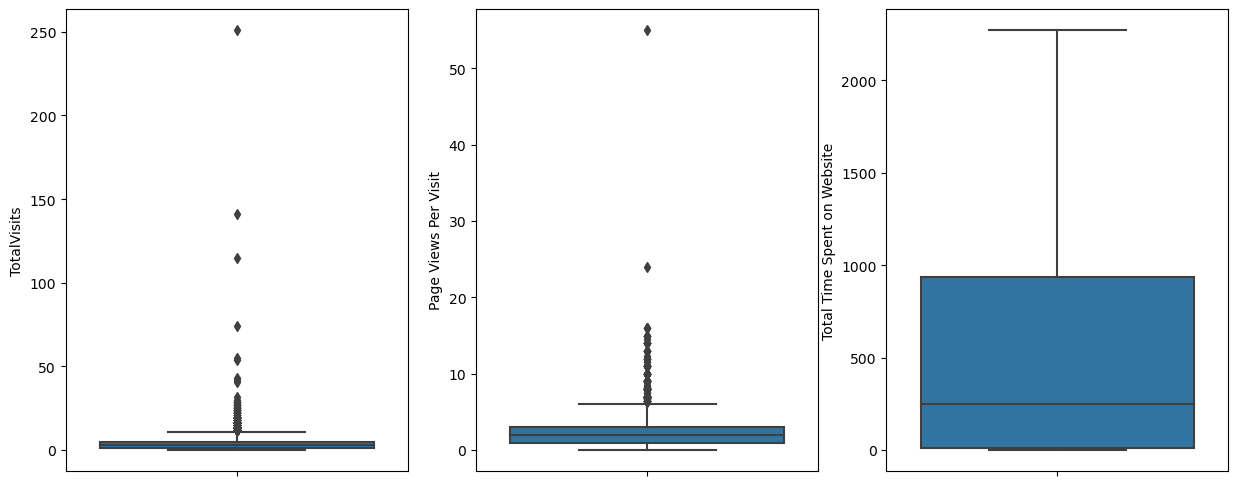

In [43]:
plt.figure(figsize=(15, 6))
plt.subplot(1,3,1)
sns.boxplot(y=df['TotalVisits'])
plt.subplot(1,3,2)
sns.boxplot(y=df['Page Views Per Visit'])
plt.subplot(1,3,3)
sns.boxplot(y=df['Total Time Spent on Website'])
plt.show()

In [44]:
df = df.drop(df[(df['TotalVisits'] > 40)].index)

In [45]:
df.shape

(9231, 16)

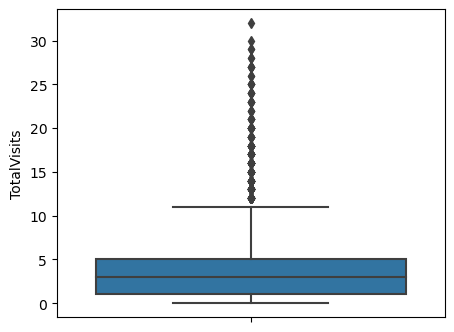

In [46]:
plt.figure(figsize=(5, 4))
sns.boxplot(y=df['TotalVisits'])
plt.show()

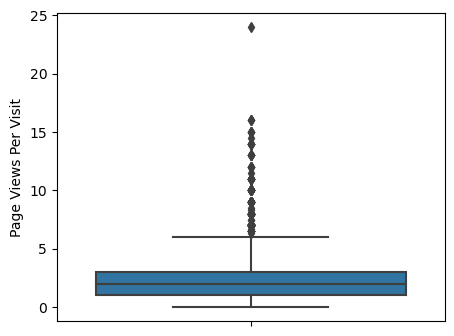

In [47]:
plt.figure(figsize=(5, 4))
sns.boxplot(y=df['Page Views Per Visit'])
plt.show()

In [48]:
df = df.drop(df[(df['Page Views Per Visit'] > 20)].index)

In [49]:
df.shape

(9230, 16)

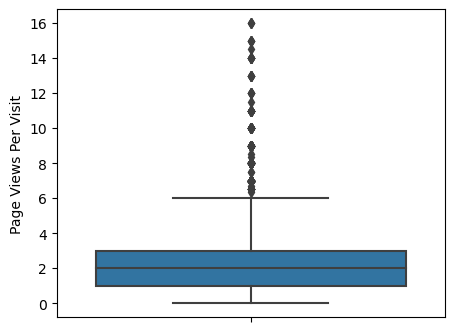

In [50]:
plt.figure(figsize=(5, 4))
sns.boxplot(y=df['Page Views Per Visit'])
plt.show()

In [51]:
df.dropna(subset=['TotalVisits'], inplace=True)

In [52]:
df.dropna(subset=['Page Views Per Visit'], inplace=True)

In [53]:
df.shape

(9093, 16)

In [54]:
(df['Converted'].value_counts(normalize=True)*100).round(2)

Undecided    61.96
Converted    38.04
Name: Converted, dtype: float64

## Some more columns to be analysed.
- While major lead originated are through API and LandingPage submissions, for both, Converted and Undecided people,
- We can see a considerably high conversions in the lead add column

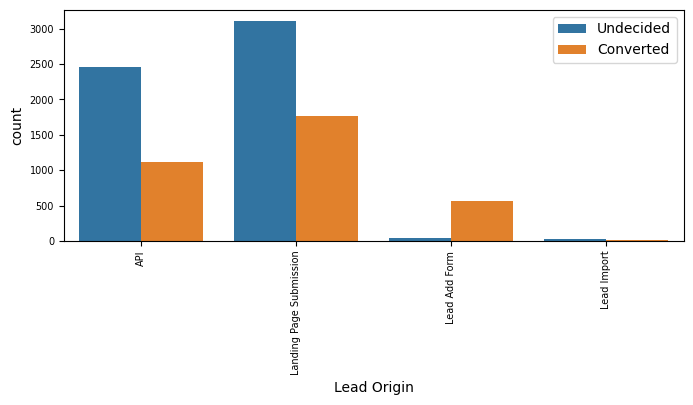

In [55]:
plt.figure(figsize=(8,3))
sns.countplot(df['Lead Origin'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(loc=1)
plt.show()

In [56]:
df.info()
### Lead Source still has missing data.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9093 entries, 0 to 9239
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Lead Origin                               9093 non-null   object 
 1   Lead Source                               9064 non-null   object 
 2   Do Not Email                              9093 non-null   object 
 3   Do Not Call                               9093 non-null   object 
 4   Converted                                 9093 non-null   object 
 5   TotalVisits                               9093 non-null   float64
 6   Total Time Spent on Website               9093 non-null   int64  
 7   Page Views Per Visit                      9093 non-null   float64
 8   Last Activity                             9093 non-null   object 
 9   Through Recommendations                   9093 non-null   object 
 10  Receive More Updates About Our Cours

#### Apart from Google, Direct Traffic, Chat and Search, it is interesting to see Reference stand out.

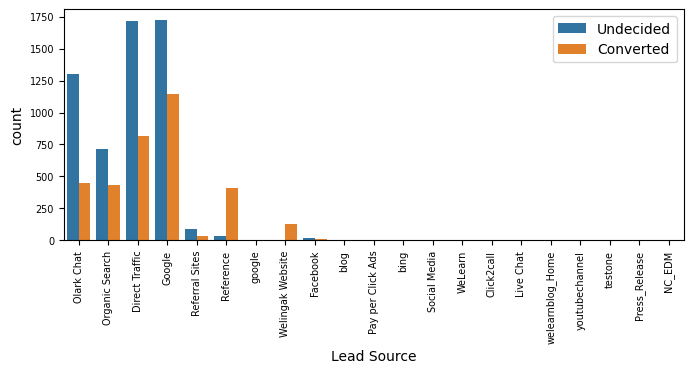

In [57]:
plt.figure(figsize=(8,3))
sns.countplot(df['Lead Source'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(loc=1)
plt.show()

In [58]:
df[['Lead Source']] = df[['Lead Source']].fillna('Not Specified')
## Filling blank records with Not Specified, as 90% of these missing data cases have been converted. 

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9093 entries, 0 to 9239
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Lead Origin                               9093 non-null   object 
 1   Lead Source                               9093 non-null   object 
 2   Do Not Email                              9093 non-null   object 
 3   Do Not Call                               9093 non-null   object 
 4   Converted                                 9093 non-null   object 
 5   TotalVisits                               9093 non-null   float64
 6   Total Time Spent on Website               9093 non-null   int64  
 7   Page Views Per Visit                      9093 non-null   float64
 8   Last Activity                             9093 non-null   object 
 9   Through Recommendations                   9093 non-null   object 
 10  Receive More Updates About Our Cours

In [60]:
df.Converted.value_counts(normalize=True)*100

Undecided    61.959749
Converted    38.040251
Name: Converted, dtype: float64

### There are quite a few columns that are not required as there is only one response by all respondents. 
- So we can drop the following
1. Do Not Call
2. Through Recommendations
3. Receive more updates about our courses
4. Update me on Supply Chain content
5. Get updates on DM content
6. I agree to pay the amount by Cheque

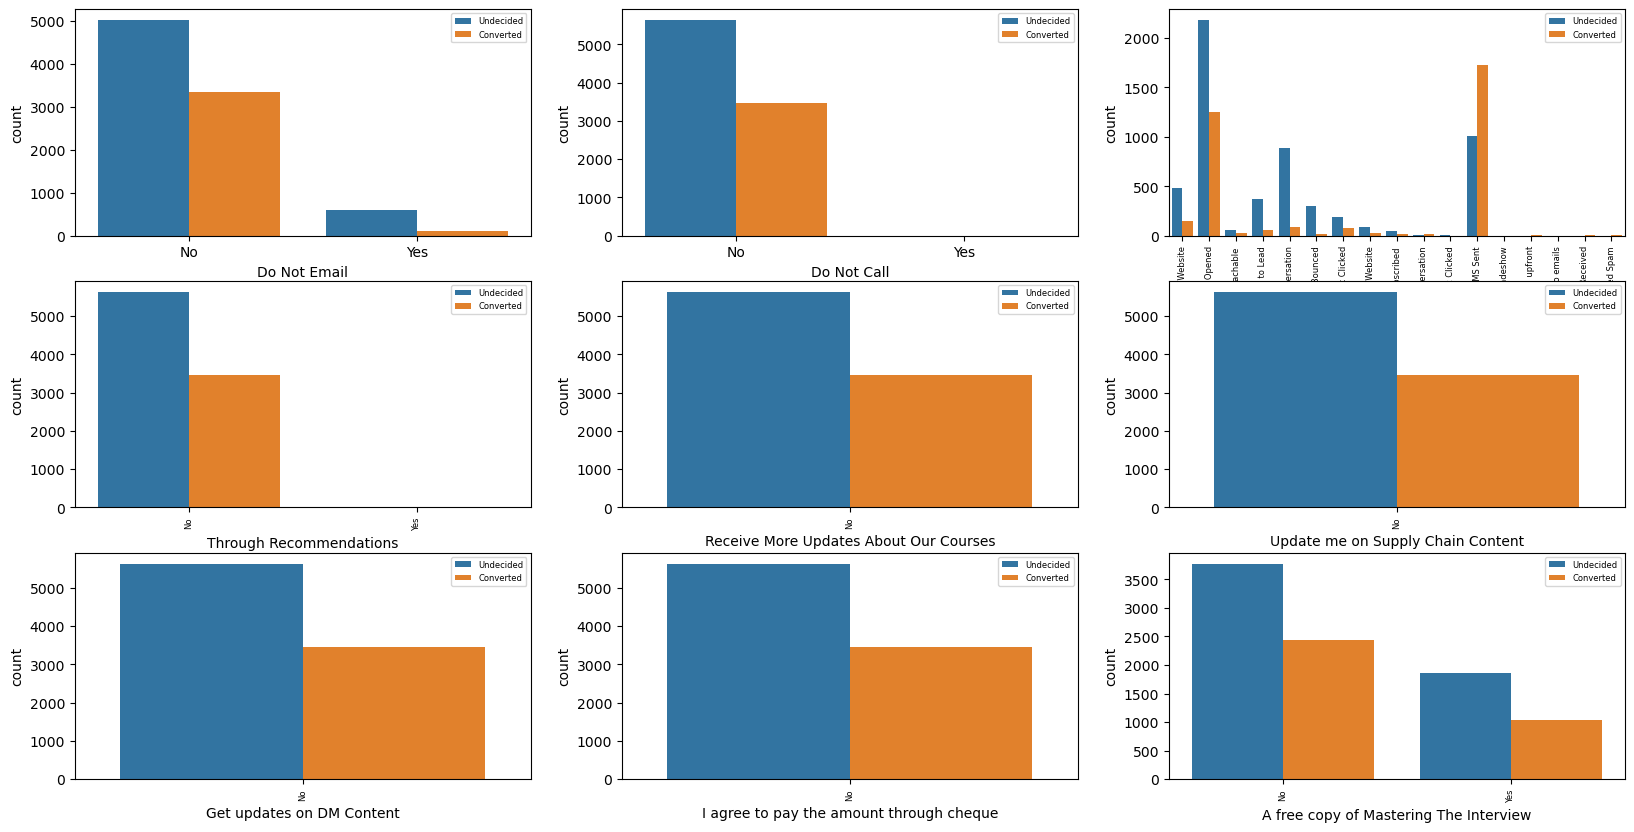

In [61]:
plt.figure(figsize=(20,10))
plt.subplot(3,3,1)
sns.countplot(df['Do Not Email'], hue=df.Converted)
plt.legend(loc=1, fontsize=6)
plt.subplot(3,3,2)
sns.countplot(df['Do Not Call'], hue=df.Converted)
plt.legend(loc=1, fontsize=6)
plt.subplot(3,3,3)
sns.countplot(df['Last Activity'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.subplot(3,3,4)
sns.countplot(df['Through Recommendations'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.subplot(3,3,5)
sns.countplot(df['Receive More Updates About Our Courses'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.subplot(3,3,6)
sns.countplot(df['Update me on Supply Chain Content'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.subplot(3,3,7)
sns.countplot(df['Get updates on DM Content'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.subplot(3,3,8)
sns.countplot(df['I agree to pay the amount through cheque'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.subplot(3,3,9)
sns.countplot(df['A free copy of Mastering The Interview'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.show()

### Just checking the difference between Last Notable Activity and Last Activity. 
- There are quite a few similarities and some differences too. 
- For the time being we will keep both the columns.

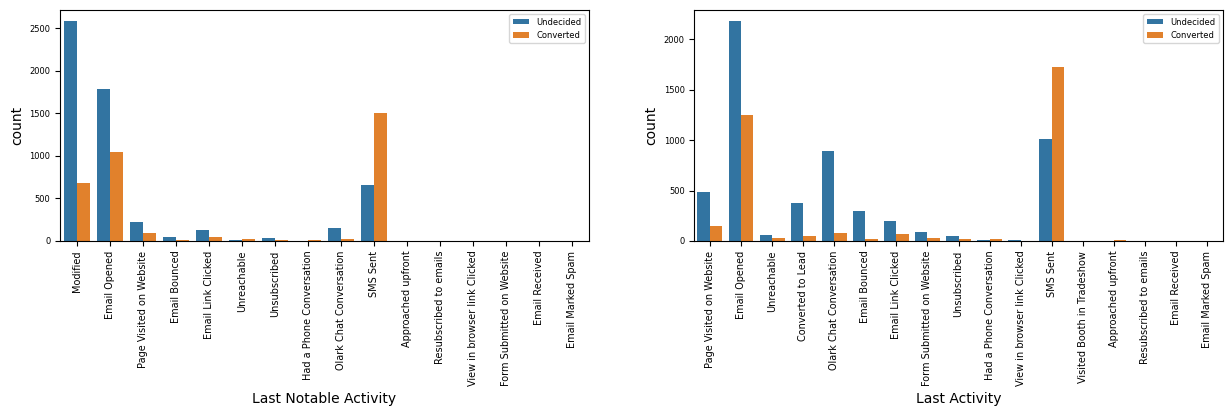

In [62]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.countplot(df['Last Notable Activity'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.subplot(1,2,2)
sns.countplot(df['Last Activity'], hue=df.Converted)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=6)
plt.legend(loc=1, fontsize=6)
plt.show()

In [63]:
df=df.drop(columns=['Do Not Call', 'Through Recommendations', 'Receive More Updates About Our Courses',
                    'Update me on Supply Chain Content','Get updates on DM Content', 
                    'I agree to pay the amount through cheque'])

In [64]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,Undecided,0.0,0,0.0,Page Visited on Website,No,Modified
1,API,Organic Search,No,Undecided,5.0,674,2.5,Email Opened,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,Converted,2.0,1532,2.0,Email Opened,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,Undecided,1.0,305,1.0,Unreachable,No,Modified
4,Landing Page Submission,Google,No,Converted,2.0,1428,1.0,Converted to Lead,No,Modified


In [65]:
df.shape

(9093, 10)

In [66]:
df.Converted= df.Converted.replace('Undecided',0)
df.Converted= df.Converted.replace('Converted',1)

In [67]:
df['Do Not Email'] = 'EM_'+ df['Do Not Email'].astype(str)
df['Lead Origin'] = 'Origin_'+ df['Lead Origin'].astype(str)
df['Lead Source'] = 'LeadS_'+ df['Lead Source'].astype(str)
df['Last Activity'] = 'Last Acti_'+ df['Last Activity'].astype(str)
df['Last Notable Activity'] = 'Last Not Act_'+ df['Last Notable Activity'].astype(str)
df['A free copy of Mastering The Interview'] = 'Mast Int_'+ df['A free copy of Mastering The Interview'].astype(str)

In [68]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity
0,Origin_API,LeadS_Olark Chat,EM_No,0,0.0,0,0.0,Last Acti_Page Visited on Website,Mast Int_No,Last Not Act_Modified
1,Origin_API,LeadS_Organic Search,EM_No,0,5.0,674,2.5,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened
2,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,1,2.0,1532,2.0,Last Acti_Email Opened,Mast Int_Yes,Last Not Act_Email Opened
3,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,0,1.0,305,1.0,Last Acti_Unreachable,Mast Int_No,Last Not Act_Modified
4,Origin_Landing Page Submission,LeadS_Google,EM_No,1,2.0,1428,1.0,Last Acti_Converted to Lead,Mast Int_No,Last Not Act_Modified


## Dummy Variables

In [69]:
Org=pd.get_dummies(df['Lead Origin'], drop_first=True)
df_1=pd.concat([df,Org], axis=1)
df_1.sample(5)

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import
4120,Origin_Landing Page Submission,LeadS_Google,EM_No,0,3.0,210,3.00,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened,1,0,0
7779,Origin_API,LeadS_Google,EM_No,0,2.0,312,2.00,Last Acti_Olark Chat Conversation,Mast Int_No,Last Not Act_Modified,0,0,0
2432,Origin_Landing Page Submission,LeadS_Google,EM_No,0,4.0,369,4.00,Last Acti_Email Opened,Mast Int_Yes,Last Not Act_Email Opened,1,0,0
897,Origin_Landing Page Submission,LeadS_Referral Sites,EM_No,0,5.0,331,1.67,Last Acti_Email Opened,Mast Int_Yes,Last Not Act_Email Opened,1,0,0
867,Origin_API,LeadS_Google,EM_No,0,2.0,121,2.00,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened,0,0,0


In [70]:
source=pd.get_dummies(df_1['Lead Source'], drop_first=True)
df_2=pd.concat([df_1,source], axis=1)
df_2.sample(5)

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel
8628,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_Yes,0,3.0,40,3.0,Last Acti_SMS Sent,Mast Int_Yes,Last Not Act_SMS Sent,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
652,Origin_API,LeadS_Google,EM_No,0,2.0,49,2.0,Last Acti_Olark Chat Conversation,Mast Int_No,Last Not Act_Modified,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1504,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,0,3.0,250,3.0,Last Acti_SMS Sent,Mast Int_Yes,Last Not Act_Modified,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3526,Origin_API,LeadS_Olark Chat,EM_No,1,0.0,0,0.0,Last Acti_SMS Sent,Mast Int_No,Last Not Act_SMS Sent,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
787,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,0,4.0,977,4.0,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
EM=pd.get_dummies(df_2['Do Not Email'], drop_first=True)
df_3=pd.concat([df_2,EM], axis=1)
df_3.sample(5)

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes
3775,Origin_API,LeadS_Olark Chat,EM_No,0,0.0,0,0.0,Last Acti_Olark Chat Conversation,Mast Int_No,Last Not Act_Modified,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1781,Origin_API,LeadS_Google,EM_No,0,3.0,505,1.5,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
349,Origin_API,LeadS_Olark Chat,EM_No,0,0.0,0,0.0,Last Acti_Olark Chat Conversation,Mast Int_No,Last Not Act_Modified,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8316,Origin_API,LeadS_Olark Chat,EM_No,0,0.0,0,0.0,Last Acti_Email Link Clicked,Mast Int_No,Last Not Act_Modified,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2193,Origin_API,LeadS_Olark Chat,EM_No,0,0.0,0,0.0,Last Acti_Olark Chat Conversation,Mast Int_No,Last Not Act_Modified,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
LastAct=pd.get_dummies(df_3['Last Activity'], drop_first=True)
df_4=pd.concat([df_3,LastAct], axis=1)
df_4.sample(5)

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow
6054,Origin_API,LeadS_Organic Search,EM_No,1,2.0,1021,2.0,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9141,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,0,3.0,63,3.0,Last Acti_Page Visited on Website,Mast Int_Yes,Last Not Act_Modified,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
282,Origin_Landing Page Submission,LeadS_Google,EM_No,0,8.0,43,8.0,Last Acti_Olark Chat Conversation,Mast Int_No,Last Not Act_Modified,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2939,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,0,6.0,1073,3.0,Last Acti_Converted to Lead,Mast Int_No,Last Not Act_Modified,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5143,Origin_Landing Page Submission,LeadS_Google,EM_No,0,4.0,60,2.0,Last Acti_Email Opened,Mast Int_No,Last Not Act_Modified,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [73]:
LastNAct=pd.get_dummies(df_4['Last Notable Activity'], drop_first=True)
df_5=pd.concat([df_4,LastNAct], axis=1)
df_5.sample(5)

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow,Last Not Act_Email Bounced,Last Not Act_Email Link Clicked,Last Not Act_Email Marked Spam,Last Not Act_Email Opened,Last Not Act_Email Received,Last Not Act_Form Submitted on Website,Last Not Act_Had a Phone Conversation,Last Not Act_Modified,Last Not Act_Olark Chat Conversation,Last Not Act_Page Visited on Website,Last Not Act_Resubscribed to emails,Last Not Act_SMS Sent,Last Not Act_Unreachable,Last Not Act_Unsubscribed,Last Not Act_View in browser link Clicked
664,Origin_API,LeadS_Organic Search,EM_No,0,3.0,144,3.0,Last Acti_Email Opened,Mast Int_No,Last Not Act_Modified,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8501,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,0,1.0,84,1.0,Last Acti_Converted to Lead,Mast Int_No,Last Not Act_Modified,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8015,Origin_Landing Page Submission,LeadS_Google,EM_No,0,2.0,63,2.0,Last Acti_Page Visited on Website,Mast Int_No,Last Not Act_Modified,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1049,Origin_API,LeadS_Google,EM_No,0,8.0,1585,4.0,Last Acti_Email Opened,Mast Int_No,Last Not Act_Modified,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5760,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,0,2.0,128,2.0,Last Acti_Email Opened,Mast Int_Yes,Last Not Act_Email Opened,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [74]:
Free=pd.get_dummies(df_5['A free copy of Mastering The Interview'], drop_first=True)
df_6=pd.concat([df_5,Free], axis=1)
df_6.sample(5)

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow,Last Not Act_Email Bounced,Last Not Act_Email Link Clicked,Last Not Act_Email Marked Spam,Last Not Act_Email Opened,Last Not Act_Email Received,Last Not Act_Form Submitted on Website,Last Not Act_Had a Phone Conversation,Last Not Act_Modified,Last Not Act_Olark Chat Conversation,Last Not Act_Page Visited on Website,Last Not Act_Resubscribed to emails,Last Not Act_SMS Sent,Last Not Act_Unreachable,Last Not Act_Unsubscribed,Last Not Act_View in browser link Clicked,Mast Int_Yes
2331,Origin_API,LeadS_Organic Search,EM_No,0,3.0,97,3.0,Last Acti_Converted to Lead,Mast Int_No,Last Not Act_Modified,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7150,Origin_Landing Page Submission,LeadS_Google,EM_No,1,8.0,735,8.0,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3828,Origin_Landing Page Submission,LeadS_Direct Traffic,EM_No,0,15.0,415,7.5,Last Acti_Page Visited on Website,Mast Int_Yes,Last Not Act_Modified,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
9059,Origin_API,LeadS_Organic Search,EM_No,1,6.0,356,2.0,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3640,Origin_Landing Page Submission,LeadS_Google,EM_No,0,4.0,208,4.0,Last Acti_Email Opened,Mast Int_No,Last Not Act_Email Opened,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
df_6=df_6.drop(columns=['Lead Origin','Lead Source','Do Not Email', 'Last Activity', 'Last Notable Activity',
                       'A free copy of Mastering The Interview'])

In [76]:
df_6.shape

(9093, 61)

In [77]:
df_6.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow,Last Not Act_Email Bounced,Last Not Act_Email Link Clicked,Last Not Act_Email Marked Spam,Last Not Act_Email Opened,Last Not Act_Email Received,Last Not Act_Form Submitted on Website,Last Not Act_Had a Phone Conversation,Last Not Act_Modified,Last Not Act_Olark Chat Conversation,Last Not Act_Page Visited on Website,Last Not Act_Resubscribed to emails,Last Not Act_SMS Sent,Last Not Act_Unreachable,Last Not Act_Unsubscribed,Last Not Act_View in browser link Clicked,Mast Int_Yes
0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,5.0,674,2.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2.0,1532,2.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,0,1.0,305,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,2.0,1428,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## Heatmap of all variables 
- More correlations with time spent od websites, page views per visit

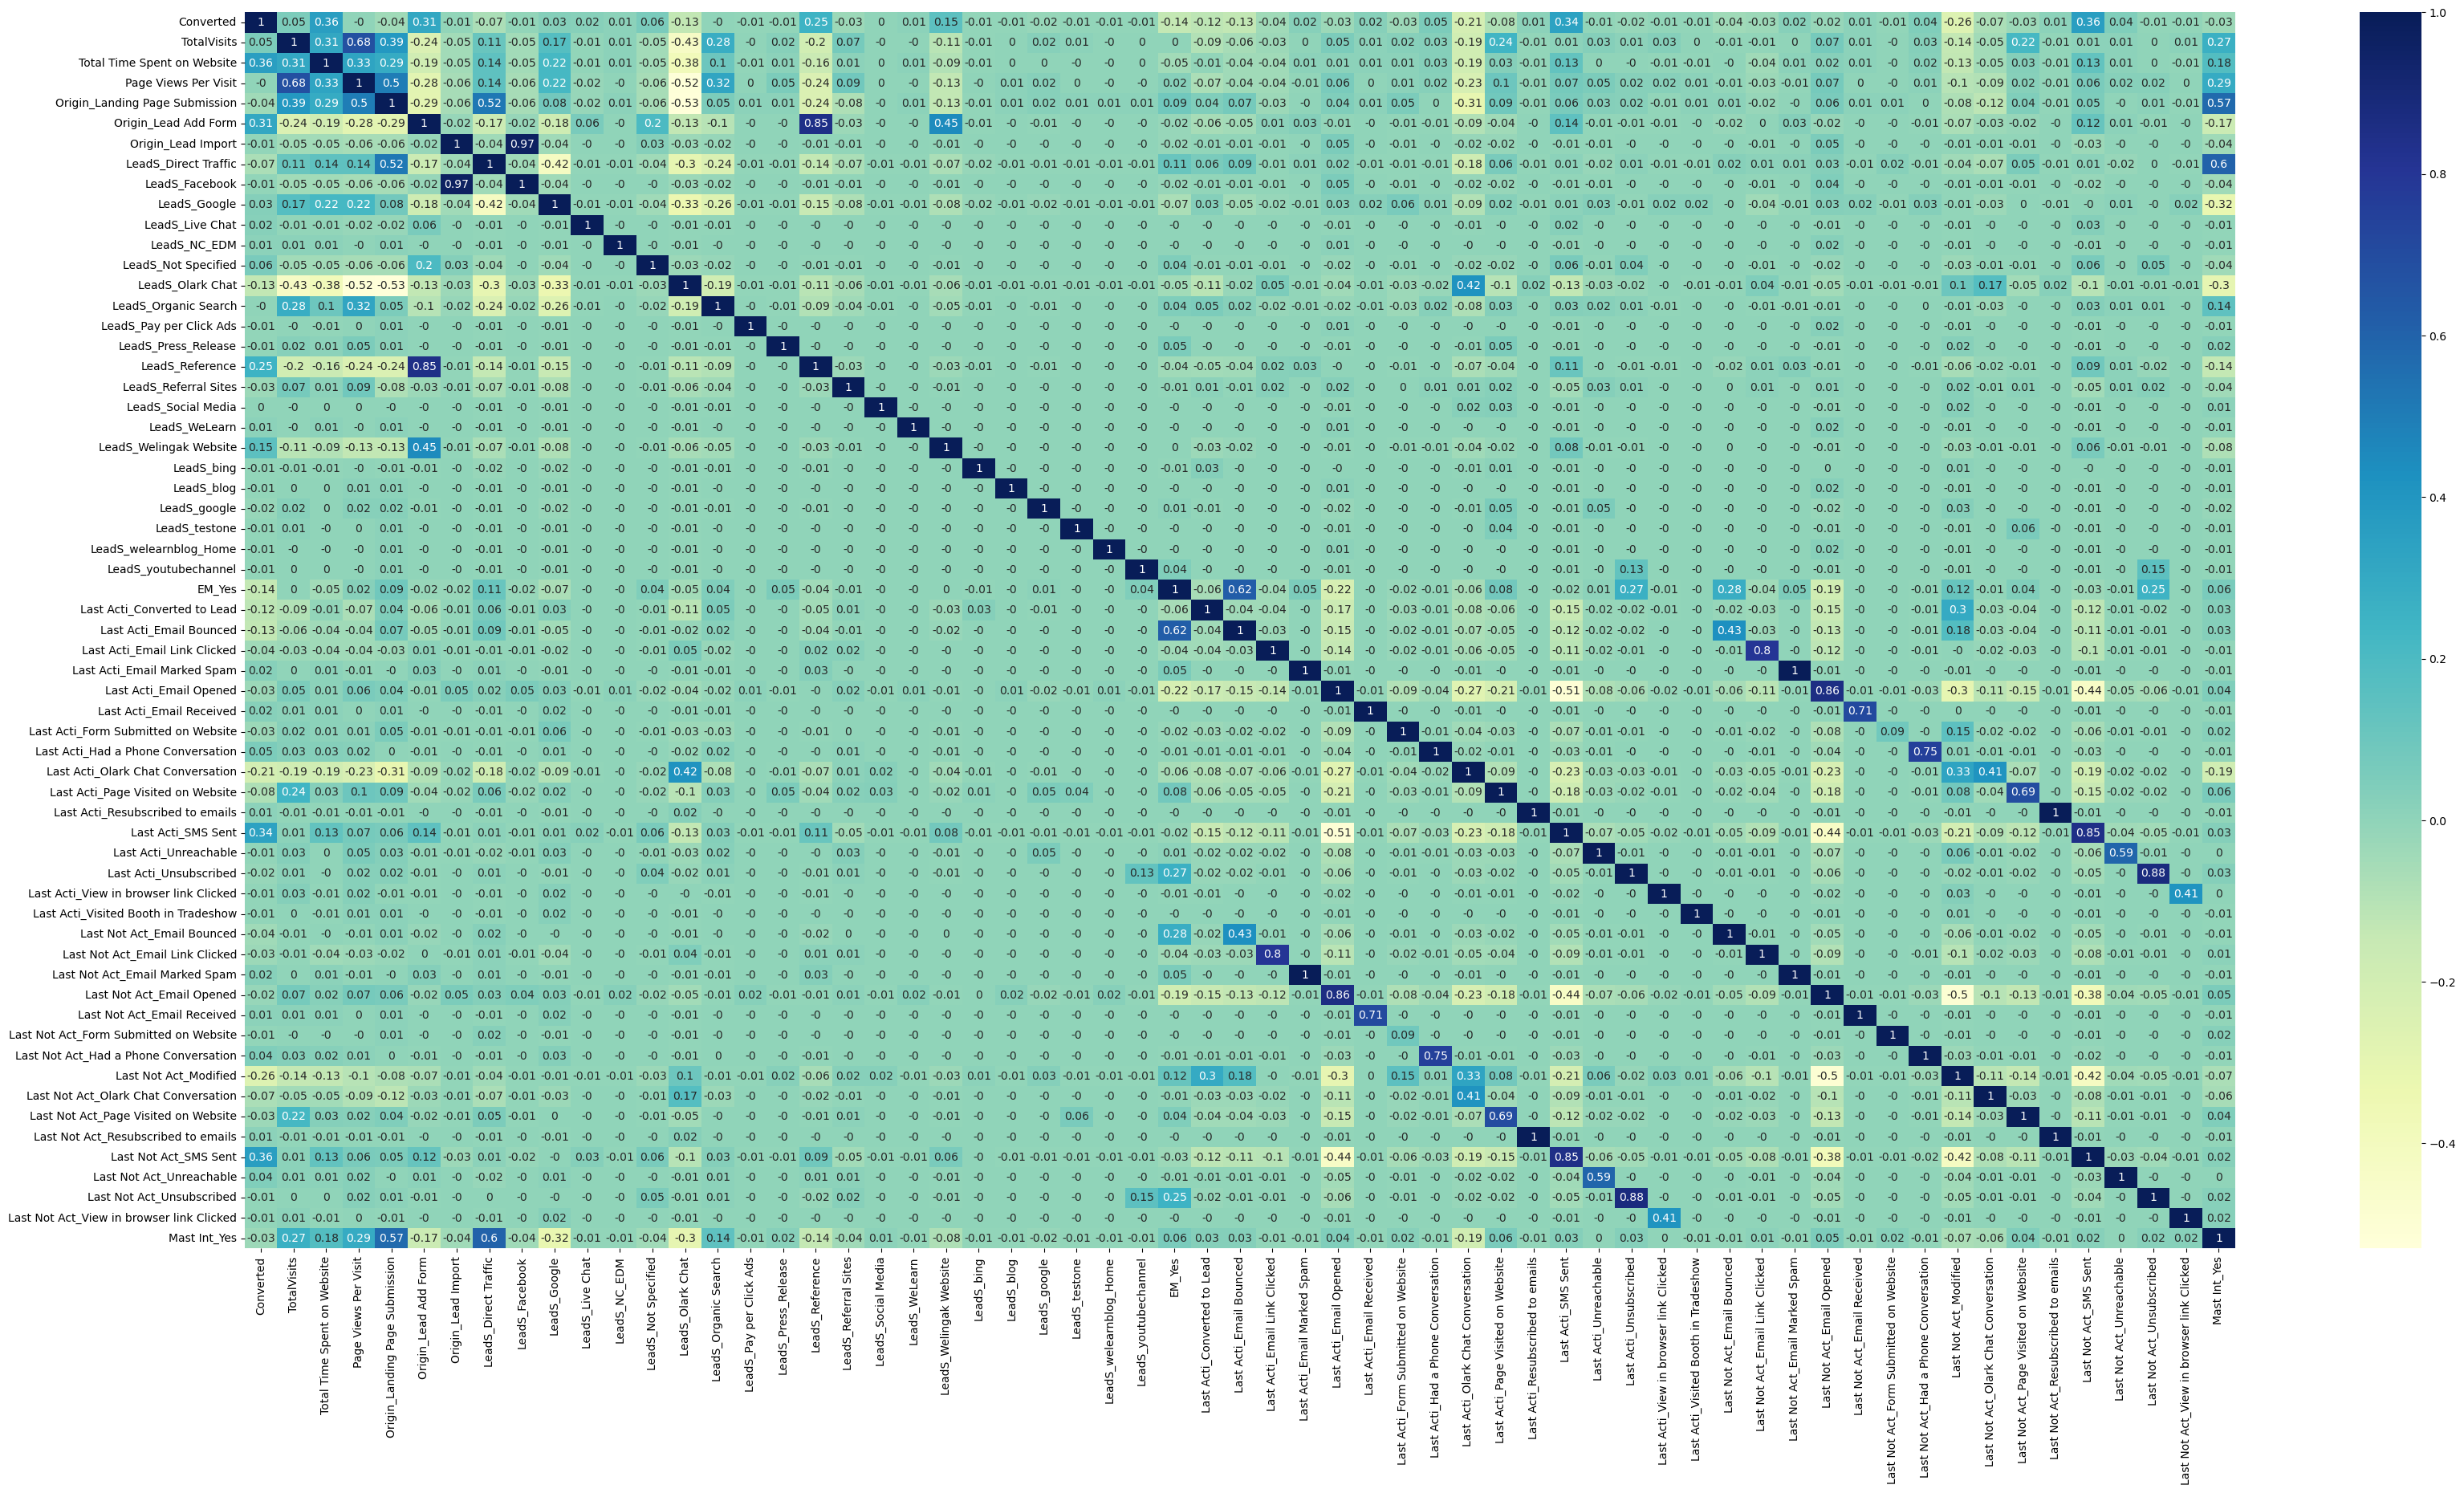

In [78]:
plt.figure(figsize=(40,20))
sns.heatmap(df_6.corr().round(2), annot= True, cmap= "YlGnBu")
plt.show()

## Splitting Train and Test Data

In [79]:
df_train, df_test = train_test_split(df_6, train_size = 0.7, test_size = 0.3, random_state = 100)

In [80]:
df_train.shape

(6365, 61)

In [81]:
df_test.shape

(2728, 61)

## Rescaling the data

In [82]:
scaler = MinMaxScaler()

In [83]:
num_vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.sample(10)

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow,Last Not Act_Email Bounced,Last Not Act_Email Link Clicked,Last Not Act_Email Marked Spam,Last Not Act_Email Opened,Last Not Act_Email Received,Last Not Act_Form Submitted on Website,Last Not Act_Had a Phone Conversation,Last Not Act_Modified,Last Not Act_Olark Chat Conversation,Last Not Act_Page Visited on Website,Last Not Act_Resubscribed to emails,Last Not Act_SMS Sent,Last Not Act_Unreachable,Last Not Act_Unsubscribed,Last Not Act_View in browser link Clicked,Mast Int_Yes
7959,1,0.18750,0.334947,0.187500,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2387,1,0.34375,0.433539,0.114375,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6958,0,0.09375,0.324824,0.093750,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
8469,0,0.06250,0.081426,0.125000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
190,0,0.00000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6677,0,0.00000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3189,0,0.06250,0.308539,0.125000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
7499,0,0.06250,0.143926,0.125000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7702,0,0.00000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5259,1,0.00000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
df_train.describe().round()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow,Last Not Act_Email Bounced,Last Not Act_Email Link Clicked,Last Not Act_Email Marked Spam,Last Not Act_Email Opened,Last Not Act_Email Received,Last Not Act_Form Submitted on Website,Last Not Act_Had a Phone Conversation,Last Not Act_Modified,Last Not Act_Olark Chat Conversation,Last Not Act_Page Visited on Website,Last Not Act_Resubscribed to emails,Last Not Act_SMS Sent,Last Not Act_Unreachable,Last Not Act_Unsubscribed,Last Not Act_View in browser link Clicked,Mast Int_Yes
count,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0,6365.0
mean,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


## Getting X and y for the train data

In [85]:
y_train = df_train.pop('Converted')
X_train = df_train

In [86]:
X_train.sample(10)

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow,Last Not Act_Email Bounced,Last Not Act_Email Link Clicked,Last Not Act_Email Marked Spam,Last Not Act_Email Opened,Last Not Act_Email Received,Last Not Act_Form Submitted on Website,Last Not Act_Had a Phone Conversation,Last Not Act_Modified,Last Not Act_Olark Chat Conversation,Last Not Act_Page Visited on Website,Last Not Act_Resubscribed to emails,Last Not Act_SMS Sent,Last Not Act_Unreachable,Last Not Act_Unsubscribed,Last Not Act_View in browser link Clicked,Mast Int_Yes
1861,0.12500,0.114437,0.25000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5879,0.15625,0.006162,0.31250,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4937,0.09375,0.102993,0.18750,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
441,0.12500,0.001320,0.25000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4760,0.12500,0.187500,0.25000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2404,0.15625,0.013644,0.15625,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
20,0.03125,0.102553,0.06250,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7196,0.03125,0.037852,0.06250,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1046,0.00000,0.000000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4466,0.09375,0.592430,0.18750,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [87]:
y_train.head()

9044    1
3022    1
6232    0
309     1
3833    0
Name: Converted, dtype: int64

## RFE -Recursive Feature Elimination
- Since we have about 60 Variables, it is important to reduce it to top 15-20

In [88]:
lr=LogisticRegression()
lr.fit(X_train, y_train)
rfe = RFE(lr, n_features_to_select = 15)
rfe= rfe.fit(X_train, y_train)

In [89]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('Origin_Landing Page Submission', False, 40),
 ('Origin_Lead Add Form', True, 1),
 ('Origin_Lead Import', False, 18),
 ('LeadS_Direct Traffic', True, 1),
 ('LeadS_Facebook', False, 30),
 ('LeadS_Google', False, 3),
 ('LeadS_Live Chat', False, 38),
 ('LeadS_NC_EDM', False, 28),
 ('LeadS_Not Specified', False, 5),
 ('LeadS_Olark Chat', False, 19),
 ('LeadS_Organic Search', False, 2),
 ('LeadS_Pay per Click Ads', False, 33),
 ('LeadS_Press_Release', False, 34),
 ('LeadS_Reference', False, 7),
 ('LeadS_Referral Sites', True, 1),
 ('LeadS_Social Media', False, 8),
 ('LeadS_WeLearn', False, 44),
 ('LeadS_Welingak Website', True, 1),
 ('LeadS_bing', False, 36),
 ('LeadS_blog', False, 16),
 ('LeadS_google', True, 1),
 ('LeadS_testone', False, 31),
 ('LeadS_welearnblog_Home', False, 26),
 ('LeadS_youtubechannel', False, 45),
 ('EM_Yes', True, 1),
 ('Last Acti_Converted to Lead', True, 1),

In [90]:
col= X_train.columns[rfe.support_]
col

Index(['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Origin_Lead Add Form', 'LeadS_Direct Traffic', 'LeadS_Referral Sites',
       'LeadS_Welingak Website', 'LeadS_google', 'EM_Yes',
       'Last Acti_Converted to Lead', 'Last Acti_Email Bounced',
       'Last Acti_Olark Chat Conversation',
       'Last Not Act_Had a Phone Conversation', 'Last Not Act_SMS Sent',
       'Last Not Act_Unreachable'],
      dtype='object')

In [91]:
 X_train.columns[~rfe.support_]

Index(['Origin_Landing Page Submission', 'Origin_Lead Import',
       'LeadS_Facebook', 'LeadS_Google', 'LeadS_Live Chat', 'LeadS_NC_EDM',
       'LeadS_Not Specified', 'LeadS_Olark Chat', 'LeadS_Organic Search',
       'LeadS_Pay per Click Ads', 'LeadS_Press_Release', 'LeadS_Reference',
       'LeadS_Social Media', 'LeadS_WeLearn', 'LeadS_bing', 'LeadS_blog',
       'LeadS_testone', 'LeadS_welearnblog_Home', 'LeadS_youtubechannel',
       'Last Acti_Email Link Clicked', 'Last Acti_Email Marked Spam',
       'Last Acti_Email Opened', 'Last Acti_Email Received',
       'Last Acti_Form Submitted on Website',
       'Last Acti_Had a Phone Conversation',
       'Last Acti_Page Visited on Website', 'Last Acti_Resubscribed to emails',
       'Last Acti_SMS Sent', 'Last Acti_Unreachable', 'Last Acti_Unsubscribed',
       'Last Acti_View in browser link Clicked',
       'Last Acti_Visited Booth in Tradeshow', 'Last Not Act_Email Bounced',
       'Last Not Act_Email Link Clicked', 'Last Not Act

In [92]:
X_train_rfe = X_train[col]

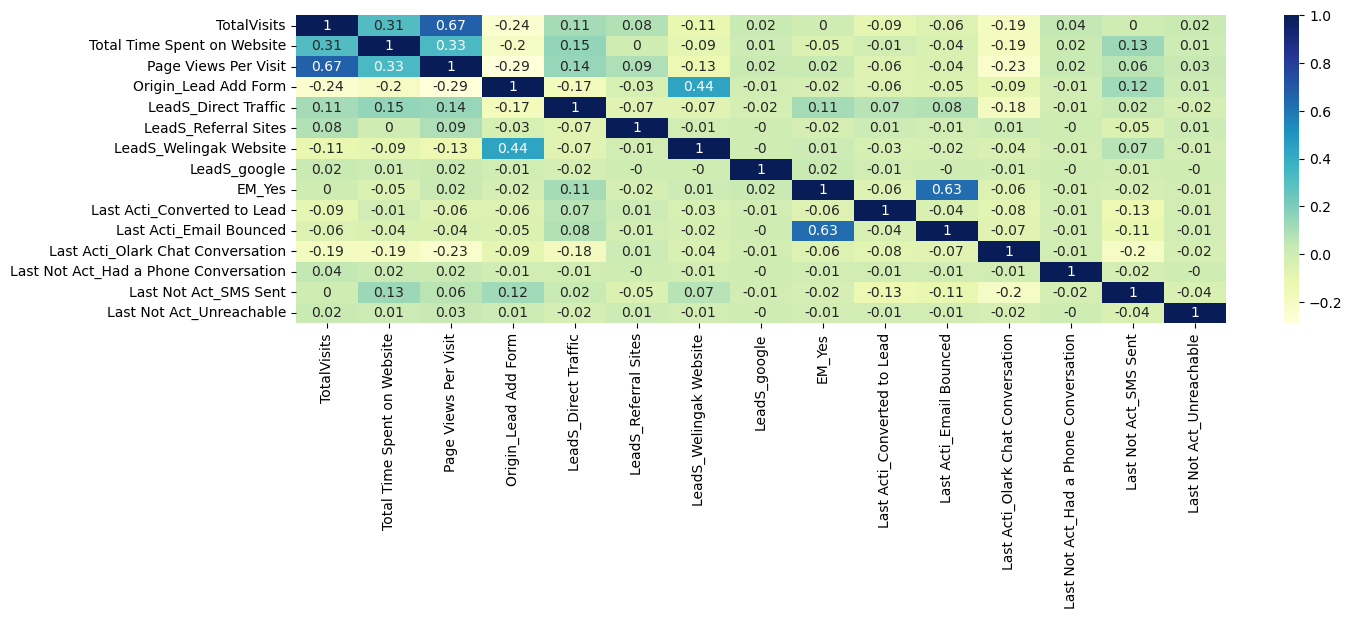

In [93]:
plt.figure(figsize=(15,4))
sns.heatmap(X_train_rfe.corr().round(2), annot= True, cmap='YlGnBu')
plt.show()

## The First read of Logreg using the 15 variables arrived at from RFE. 
-

In [94]:
log_1 = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial())
res=log_1.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6365
Model:                            GLM   Df Residuals:                     6350
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3078.3
Date:                Sun, 17 Sep 2023   Deviance:                       6156.6
Time:                        15:18:06   Pearson chi2:                 7.23e+03
No. Iterations:                    20   Pseudo R-squ. (CS):             0.3060
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [95]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Page Views Per Visit,4.00
0,TotalVisits,3.53
1,Total Time Spent on Website,1.98
8,EM_Yes,1.82
10,Last Acti_Email Bounced,1.74
4,LeadS_Direct Traffic,1.41
13,Last Not Act_SMS Sent,1.37
3,Origin_Lead Add Form,1.33
6,LeadS_Welingak Website,1.27
9,Last Acti_Converted to Lead,1.05


In [96]:
X_train_rfe.drop('TotalVisits', axis = 1, inplace = True)

In [97]:
X_train_rfe1= sm.add_constant(X_train_rfe)
log_2 = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial())
res=log_2.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6365
Model:                            GLM   Df Residuals:                     6351
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3078.4
Date:                Sun, 17 Sep 2023   Deviance:                       6156.8
Time:                        15:18:07   Pearson chi2:                 7.24e+03
No. Iterations:                    20   Pseudo R-squ. (CS):             0.3060
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [98]:
X_train_rfe.drop('LeadS_google', axis = 1, inplace = True)

In [99]:
X_train_rfe1= sm.add_constant(X_train_rfe)
log_2 = sm.GLM(y_train,X_train_rfe, family = sm.families.Binomial())
res=log_2.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6365
Model:                            GLM   Df Residuals:                     6352
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3080.4
Date:                Sun, 17 Sep 2023   Deviance:                       6160.8
Time:                        15:18:07   Pearson chi2:                 7.25e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3055
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [211]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,Page Views Per Visit,2.04
0,Total Time Spent on Website,1.92
6,EM_Yes,1.81
8,Last Acti_Email Bounced,1.73
3,LeadS_Direct Traffic,1.41
11,Last Not Act_SMS Sent,1.37
2,Origin_Lead Add Form,1.33
5,LeadS_Welingak Website,1.27
7,Last Acti_Converted to Lead,1.05
4,LeadS_Referral Sites,1.03


## Record wise probabilities (score) and then comparing the predicted conversions with actual conversions.
- If we take a 0.5 cutoff for the probability scores (after comparing the table on actual conversions and probability of conversions), our predictions seem to be a close match. Any score greater than 0.50 is a conversion and lesser score is considered undecided.

In [101]:
y_train_pred = res.predict(X_train_rfe)
y_train_pred[:10]

9044    0.861611
3022    0.963575
6232    0.140867
309     0.397101
3833    0.341923
1050    0.727555
5239    0.500000
4708    0.802392
6927    0.364050
8596    0.628929
dtype: float64

In [102]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.86161125, 0.96357477, 0.14086669, 0.39710124, 0.34192284,
       0.72755478, 0.5       , 0.80239228, 0.36405004, 0.62892944])

In [212]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final.head(10)

,Converted,Conversion_Prob
0,1,0.861611
1,1,0.963575
2,0,0.140867
3,1,0.397101
4,0,0.341923
5,1,0.727555
6,0,0.500000
7,1,0.802392
8,0,0.364050
9,0,0.628929


In [104]:
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.50 else 0)
y_train_pred_final.head(10)


,Converted,Conversion_Prob,Predicted
0,1,0.861611,1
1,1,0.963575,1
2,0,0.140867,0
3,1,0.397101,0
4,0,0.341923,0
5,1,0.727555,1
6,0,0.500000,0
7,1,0.802392,1
8,0,0.364050,0
9,0,0.628929,1


## Is 0.5 a good cutoff? 
- When we take this as cutoff, there is always a chance of classifying customers incorrectly as converted, when actually they are not. Also there is a chance of classifying incorrectly the undecided customers as converted.
- For that we need to check the confusion matrix
- the accuracy with a 0.50 cutoff of 78.7% which is quite good. However, is it the best cutoff value. 
- Actually with the current model we are able to predict 70% (sensitivty) of the conversions correctly. Which is a good prediction. Although, it also means that we will be missing out on 30% of customers who are likely to convert. This is a bigger challenge in this particular case. Since conversions, per se, are so low, it is important that we do not miss out on any key customers here.
- But, we are able to predict non-conversions (undecided) even better, which is at 83% (Specificity). 
- There is a gap in how well we are predicted conversions vs the undecided ones. It would be good to have lesser gap between the two. Hence we look for a better cutoff option. 

In [105]:
from sklearn import metrics

In [106]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[3289  628]
 [ 723 1725]]


In [107]:
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.787745483110762


In [108]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [109]:
# Calculate the sensitivity

TP/(TP+FN)

0.7046568627450981

In [110]:
# Calculate the specificity

TN/(TN+FP)

0.8396732193004851

## Receiver Operating Characteristic (ROC) Curves. 
- The curve shows a sharp initial plot curve. This shows the ration between TPR and FPR. The plot moves initially towards the upper left corner which is an indication of a good fit of the model. 
- It also covers a very good proportion of the are of the curve.

In [111]:
# ROC function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [112]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )

In [113]:
# Import matplotlib to plot the ROC curve

import matplotlib.pyplot as plt

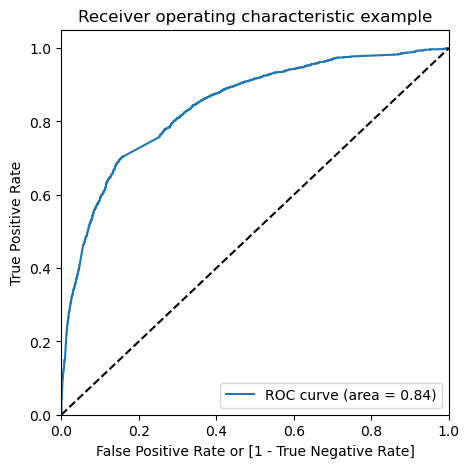

In [114]:
# Call the ROC function

draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

In [115]:
# Let's create columns with different probability cutoffs 

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.861611,1,1,1,1,1,1,1,1,1,1,0
1,1,0.963575,1,1,1,1,1,1,1,1,1,1,1
2,0,0.140867,0,1,1,0,0,0,0,0,0,0,0
3,1,0.397101,0,1,1,1,1,0,0,0,0,0,0
4,0,0.341923,0,1,1,1,1,0,0,0,0,0,0


## To find what is best cutoff. 
- Here we plot a graph of three lines intersecting each other as one point. Which is that of sensitivity, specificity and accuracy. 
- plotted on the x axis is the probabilities. 
- We observe that a cutoff closer to 0.45 is more feasible. In this case we have taken 0.46. 
- At this point, the correct prediction of conversions is as high as 79%. So we have improved the prediction of conversions. Albeit, the overall accuracy of the model drops to 74.5% from 78.7%. Which is a better situation to be in as we are able to predict conversions better. 

In [116]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.384603  1.000000  0.000000
0.1   0.1  0.551296  0.973856  0.287210
0.2   0.2  0.620267  0.938725  0.421241
0.3   0.3  0.685310  0.897059  0.552974
0.4   0.4  0.731029  0.838235  0.664029
0.5   0.5  0.787745  0.704657  0.839673
0.6   0.6  0.783818  0.620915  0.885627
0.7   0.7  0.769992  0.521242  0.925453
0.8   0.8  0.727258  0.343954  0.966811
0.9   0.9  0.668028  0.151552  0.990809


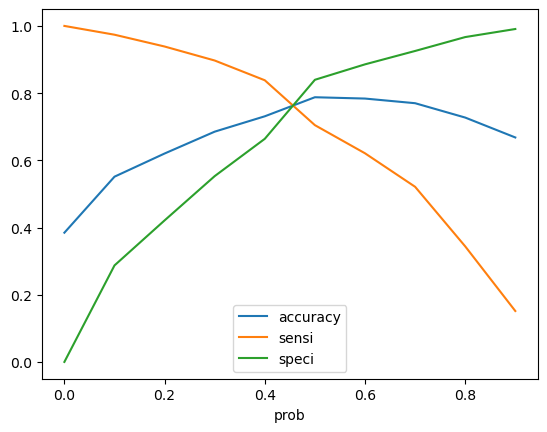

In [117]:
# Let's plot it as well

cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [219]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.46 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,final_predicted
0,1,0.861611,1
1,1,0.963575,1
2,0,0.140867,0
3,1,0.397101,0
4,0,0.341923,0


In [220]:
# Let's check the accuracy now

metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7453260015710919

In [221]:
# Let's create the confusion matrix once again

confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[2821, 1096],
       [ 525, 1923]], dtype=int64)

In [222]:
# Let's evaluate the other metrics as well

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [223]:
# Calculate Sensitivity

TP/(TP+FN)

0.7855392156862745

In [224]:
# Calculate Specificity

TN/(TN+FP)

0.720194026040337

In [162]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.2964003063569058


In [163]:
# Positive predictive value 
print (TP / float(TP+FP))

0.6293103448275862


In [164]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8524590163934426


## Precision and Recall

In [165]:
#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3289,  628],
       [ 723, 1725]], dtype=int64)

### Precision
### TP / TP + FP

In [167]:
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.7331066723331917

### Recall
#### TP / TP + FN

In [169]:
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.7046568627450981

## Precision Recall Tradeoff

confusion[1,1]/(confusion[1,0]+confusion[1,1])

In [170]:
from sklearn.metrics import precision_recall_curve

In [171]:
y_train_pred_final.Converted, y_train_pred_final.Predicted

(0       1
 1       1
 2       0
 3       1
 4       0
        ..
 6360    0
 6361    1
 6362    0
 6363    1
 6364    1
 Name: Converted, Length: 6365, dtype: int64,
 0       1
 1       1
 2       0
 3       0
 4       0
        ..
 6360    0
 6361    0
 6362    0
 6363    0
 6364    1
 Name: Predicted, Length: 6365, dtype: int64)

In [172]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

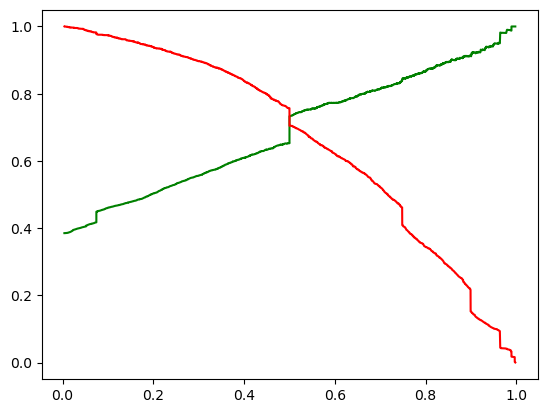

In [173]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [262]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.51 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,final_predicted
0,1,0.861611,1
1,1,0.963575,1
2,0,0.140867,0
3,1,0.397101,0
4,0,0.341923,0


In [263]:
# Let's check the accuracy now

metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7897879025923017

In [266]:
# Let's create the confusion matrix once again

confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3311,  606],
       [ 732, 1716]], dtype=int64)

In [267]:
# Let's evaluate the other metrics as well

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [268]:
# Calculate Precision

TP/(TP+FP)

0.7390180878552972

In [269]:
# Calculate Recall

TP/(TP+FN)

0.7009803921568627

## Making predictions on test set

#### The test model shows an accuracy of 73.3% 
- The Sensitivity (77%) and Specifity (71%) scores are also quite comparable as in the train data. 
- The desired parameters of Sensitivity is higher and hence makes sense to go ahead with this model.

In [124]:
# Scale the test set as well using just 'transform'

num_vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

df_test.sample(10)

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow,Last Not Act_Email Bounced,Last Not Act_Email Link Clicked,Last Not Act_Email Marked Spam,Last Not Act_Email Opened,Last Not Act_Email Received,Last Not Act_Form Submitted on Website,Last Not Act_Had a Phone Conversation,Last Not Act_Modified,Last Not Act_Olark Chat Conversation,Last Not Act_Page Visited on Website,Last Not Act_Resubscribed to emails,Last Not Act_SMS Sent,Last Not Act_Unreachable,Last Not Act_Unsubscribed,Last Not Act_View in browser link Clicked,Mast Int_Yes
2043,1,0.083333,0.716129,0.125000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
100,0,0.291667,0.752535,0.218750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1675,1,0.333333,0.984793,0.500000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
297,0,0.166667,0.005530,0.250000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
8508,0,0.083333,0.102765,0.125000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8143,0,0.333333,0.683410,0.166875,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2778,0,0.125000,0.258986,0.187500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1329,1,0.250000,0.363134,0.375000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3299,1,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7795,1,0.083333,0.006452,0.062500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [125]:
y_test = df_test.pop('Converted')
X_test = df_test

In [126]:
X_test.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,LeadS_Direct Traffic,LeadS_Facebook,LeadS_Google,LeadS_Live Chat,LeadS_NC_EDM,LeadS_Not Specified,LeadS_Olark Chat,LeadS_Organic Search,LeadS_Pay per Click Ads,LeadS_Press_Release,LeadS_Reference,LeadS_Referral Sites,LeadS_Social Media,LeadS_WeLearn,LeadS_Welingak Website,LeadS_bing,LeadS_blog,LeadS_google,LeadS_testone,LeadS_welearnblog_Home,LeadS_youtubechannel,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Email Link Clicked,Last Acti_Email Marked Spam,Last Acti_Email Opened,Last Acti_Email Received,Last Acti_Form Submitted on Website,Last Acti_Had a Phone Conversation,Last Acti_Olark Chat Conversation,Last Acti_Page Visited on Website,Last Acti_Resubscribed to emails,Last Acti_SMS Sent,Last Acti_Unreachable,Last Acti_Unsubscribed,Last Acti_View in browser link Clicked,Last Acti_Visited Booth in Tradeshow,Last Not Act_Email Bounced,Last Not Act_Email Link Clicked,Last Not Act_Email Marked Spam,Last Not Act_Email Opened,Last Not Act_Email Received,Last Not Act_Form Submitted on Website,Last Not Act_Had a Phone Conversation,Last Not Act_Modified,Last Not Act_Olark Chat Conversation,Last Not Act_Page Visited on Website,Last Not Act_Resubscribed to emails,Last Not Act_SMS Sent,Last Not Act_Unreachable,Last Not Act_Unsubscribed,Last Not Act_View in browser link Clicked,Mast Int_Yes
6297,0.375,0.476037,0.5625,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8181,0.000,0.000000,0.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7000,0.000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8052,0.000,0.000000,0.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2917,0.000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [127]:
X_test_rfe = X_test[col]
X_test_rfe.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Origin_Lead Add Form,LeadS_Direct Traffic,LeadS_Referral Sites,LeadS_Welingak Website,LeadS_google,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Olark Chat Conversation,Last Not Act_Had a Phone Conversation,Last Not Act_SMS Sent,Last Not Act_Unreachable
6297,0.375,0.476037,0.5625,0,0,0,0,0,0,0,0,0,0,1,0
8181,0.000,0.000000,0.0000,1,0,0,0,0,0,0,0,0,0,1,0
7000,0.000,0.000000,0.0000,0,0,0,0,0,0,0,0,1,0,0,0
8052,0.000,0.000000,0.0000,1,0,0,0,0,0,0,0,0,0,1,0
2917,0.000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
X_test_rfe.drop(['TotalVisits', 'LeadS_google'], 1, inplace = True)

In [129]:
X_test_rfe1 = sm.add_constant(X_test_rfe)

In [133]:
# Make predictions on the test set and store it in the variable 'y_test_pred'
y_test_pred = res.predict(X_test_rfe)
y_test_pred[:10]

6297    0.447223
8181    0.963575
7000    0.074493
8052    0.963575
2917    0.500000
2723    0.416395
9072    0.258544
5420    0.023347
7045    0.996309
4082    0.058771
dtype: float64

In [134]:
# Converting y_pred to a dataframe

y_pred_1 = pd.DataFrame(y_test_pred)

In [129]:
X_test.head()

,Total Time Spent on Website,Page Views Per Visit,Origin_Lead Add Form,LeadS_Direct Traffic,LeadS_Referral Sites,LeadS_Welingak Website,EM_Yes,Last Acti_Converted to Lead,Last Acti_Email Bounced,Last Acti_Olark Chat Conversation,Last Not Act_Had a Phone Conversation,Last Not Act_SMS Sent,Last Not Act_Unreachable
6297,0.476037,0.5625,0,0,0,0,0,0,0,0,0,1,0
8181,0.000000,0.0000,1,0,0,0,0,0,0,0,0,1,0
7000,0.000000,0.0000,0,0,0,0,0,0,0,1,0,0,0
8052,0.000000,0.0000,1,0,0,0,0,0,0,0,0,1,0
2917,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,0


In [135]:
# Let's see the head

y_pred_1.head()

,0
6297,0.447223
8181,0.963575
7000,0.074493
8052,0.963575
2917,0.500000


In [136]:
# Converting y_test to dataframe

y_test_df = pd.DataFrame(y_test)

In [137]:
# Remove index for both dataframes to append them side by side 

y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [138]:
# Append y_test_df and y_pred_1

y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [139]:
# Check 'y_pred_final'

y_pred_final.head()

,Converted,0
0,1,0.447223
1,0,0.963575
2,0,0.074493
3,1,0.963575
4,0,0.500000


In [140]:
# Rename the column 

y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})

In [141]:
# Let's see the head of y_pred_final

y_pred_final.head()

,Converted,Conversion_Prob
0,1,0.447223
1,0,0.963575
2,0,0.074493
3,1,0.963575
4,0,0.500000


In [270]:
# Make predictions on the test set using 0.46 as the cutoff

y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.46 else 0)

In [271]:
# Check y_pred_final

y_pred_final.head()

,Converted,Conversion_Prob,final_predicted
0,1,0.447223,0
1,0,0.963575,1
2,0,0.074493,0
3,1,0.963575,1
4,0,0.500000,1


In [272]:
# Let's check the overall accuracy

metrics.accuracy_score(y_pred_final['Converted'], y_pred_final.final_predicted)

0.7338709677419355

In [273]:
confusion2 = metrics.confusion_matrix(y_pred_final['Converted'], y_pred_final.final_predicted )
confusion2

array([[1222,  495],
       [ 231,  780]], dtype=int64)

In [274]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [275]:
# Calculate sensitivity
TP / float(TP+FN)

0.771513353115727

In [276]:
# Calculate specificity
TN / float(TN+FP)

0.7117064647641235